# AI Generate Art using GAN

Generative Adversarial Network (GAN). A GAN consists of two neural networks, a generator and a discriminator, that work together to generate new, synthetic data that is similar to a training dataset. The generator creates new samples, while the discriminator tries to determine whether each sample is real or fake. As the generator and discriminator improve, the synthetic data generated by the GAN becomes increasingly realistic.

Resource: https://github.com/eriklindernoren/Keras-GAN

## Implement a GAN to generate images of handwritten digits

In [1]:
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


class GAN():
    def __init__(self):
        # Input shape
        self.img_rows   = 28
        self.img_cols   = 28
        self.channels   = 1
        self.latent_dim = 100
        self.img_shape = (
            self.img_rows, 
            self.img_cols, 
            self.channels
        )

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        print("Discriminator:\n")
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        print("\nGenerator:\n")
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        # model summary
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        image = model(noise)
        return Model(noise, image)


    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        # model summary
        model.summary()

        image = Input(shape=self.img_shape)
        validity = model(image)
        return Model(image, validity)


    def train(self, epochs, batch_size=128, save_interval=50):
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            ##  Train Discriminator ##

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            disc_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            ##  Train Generator ##

            # Train the generator (wants discriminator to mistake images as real)
            gen_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print(f' Epoch {epoch + 1} '.center(30, '-'))
            print(f'generator loss: {gen_loss:.2f}, discriminator loss: {disc_loss[0]:.2f}')
            print(f'Accuracy: {100 * disc_loss[1]:.2f}%\n')

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_images(epoch)


    def save_images(self, epoch):
        row, col = 5, 5
        noise = np.random.normal(0, 1, (row * col, self.latent_dim))
        generated_images = self.generator.predict(noise)

        # Rescale images 0 - 1
        generated_images = 0.5 * generated_images + 0.5

        fig, axes = plt.subplots(row, col)
        count = 0
        for i in range(row):
            for j in range(col):
                axes[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
                axes[i, j].axis('off')
                count += 1
        
        fig.savefig("./images/mnist_%d.png" % epoch)
        plt.close()


    def generate_art(self, row=1, column=1, save_image=False):
        noise = np.random.normal(0, 1, (row * column, self.latent_dim))
        generated_images = self.generator.predict(noise)

        # Rescale images 0 - 1
        generated_images = 0.5 * generated_images + 0.5
        image_size = len(generated_images)

        # Visualize the prediction of generated images
        fig, axes = plt.subplots(row, column)

        # Iterate over the generated images and plot them
        count = 0
        for i in range(row):
            for j in range(column):
                image = generated_images[count, :, :, 0]
                axes[i, j].imshow(image, cmap='gray')
                axes[i, j].set_title('Label: {}'.format(count + 1))
                axes[i, j].axis('off')
                count += 1

                # Save the image to a file
                if save_image == True:
                    plt.imwrite(f'generated_image_{count}.png', image)
        
        plt.tight_layout()
        plt.show()

In [2]:
# build model
model = GAN()

Discriminator:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 

In [ ]:
# train model
model.train(epochs=30000, batch_size=32, save_interval=300)

## Finally, to generate images, you can call the generator model and pass in some random noise as input



1/1 [==============================] - 0s 33ms/step


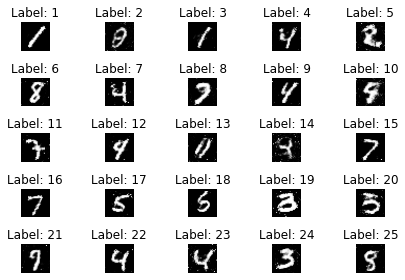

In [4]:
model.generate_art(row=5, column=5, save_image=False)

## Save the Generator model


In [ ]:
# Save the generator model
model.generator.save("save_model.h5")

## Load a trained Generator model and use it to generate images

1/1 [==============================] - 0s 125ms/step


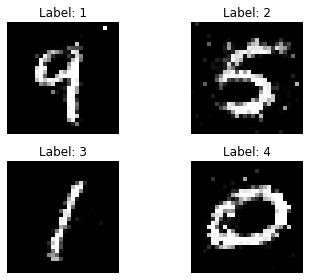

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

latent_dim = 100

# Load the model (generator)
generator = tf.keras.models.load_model('save_model.h5', compile=False)

def generate_art(row=1, column=1, save_image=False):
    noise = np.random.normal(0, 1, (row * column, latent_dim))
    generated_images = generator.predict(noise)

    # Convert the generated images to uint8 and rescale them to the range [0, 255]
    generated_images = 0.5 * generated_images + 0.5
    image_size = len(generated_images)

    # Visualize the prediction of generated images
    fig, axes = plt.subplots(row, column)

    # Iterate over the generated images and plot them
    count = 0
    for i in range(row):
        for j in range(column):
            image = generated_images[count, :, :, 0]
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title('Label: {}'.format(count + 1))
            axes[i, j].axis('off')
            count += 1

            # Save the image to a file
            if save_image == True:
                plt.imwrite(f'generated_image_{count}.png', image)
    
    plt.tight_layout()
    plt.show()

# Generate some random noise as input for the generator
generate_art(row=2, column=2, save_image=False)

## Save and Load GAN Model

In [ ]:
import pickle

# save model
with open('model.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

# load model
with open('model.pkl', 'rb') as input:
    model = pickle.load(input)
    model.generate_art()